In [14]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import cross_val_score

In [5]:
df = pd.read_csv('dataset_politik_combined.csv')
df = df.drop_duplicates()
df = df.dropna()

In [32]:
df.head()

,full_text,processed_text_sastrawi,label
0,marah cawapres mentri yg jd cawapres menkopolh...,marah cawapres tri yg jd cawapres menkopolhukam,1
1,mahfud md resmi diumumkan cawapres ganjaar pra...,mahfud md resmi umum cawapres ganjaar pranowo ...,0
2,anakanak keberadaan cawapres prabowo gibran ra...,anakanak ada cawapres prabowo gibran rakabumin...,1
3,kalo tdk knp gerombolan pecundang spt diam beg...,kalo tdk knp gerombol cundang spt diam bego pu...,1
4,klo kiat rujuk dlu bg sajak jdi cawapres basan...,klo kiat rujuk dlu bg sajak jdi cawapres basan...,1


In [23]:
embedding_index = {}
with open('glove_50dim_wiki.id.case.text.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text_sastrawi'])
sequences = tokenizer.texts_to_sequences(df['processed_text_sastrawi'])

# Mengubah teks menjadi urutan dan padding
sequences = tokenizer.texts_to_sequences(df['processed_text_sastrawi'])
max_length = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_length)

# Label dalam format asli
y = df['label']

# Pembagian data DataFrame
df_train, df_temp = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_temp, test_size=1/3, random_state=42)

# Menggunakan TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(df['processed_text_sastrawi'])
train_X_tfidf = tfidf_vect.transform(df_train['processed_text_sastrawi'])
test_X_tfidf = tfidf_vect.transform(df_test['processed_text_sastrawi'])

# Label dalam format asli
y_train = df_train['label']
y_test = df_test['label']

# Pelatihan model SVM
model = SVC(kernel='linear')
history = model.fit(train_X_tfidf, y_train)

# Prediksi dan evaluasi
predictions = model.predict(test_X_tfidf)
accuracy = accuracy_score(predictions, y_test) * 100
accuracy = round(accuracy, 1)

print(f"SVM Accuracy: {accuracy}%")

# Melakukan validasi silang
scores = cross_val_score(model, train_X_tfidf, y_train, cv=5)  # cv adalah jumlah fold untuk validasi silang

print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

Found 370013 word vectors.
SVM Accuracy: 76.3%
Cross-validation scores: [0.76100898 0.76400171 0.76176219 0.77202737 0.76775021]
Mean cross-validation score: 0.7653100931832055


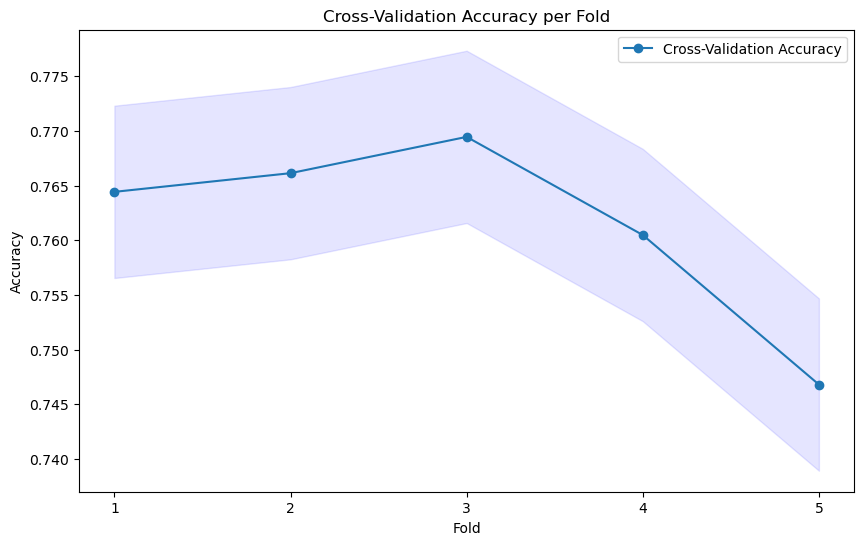

In [22]:
# Anggap 'scores' adalah array yang dihasilkan dari cross_val_score dengan 20 fold
num_folds = len(scores)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_folds+1), scores, label='Cross-Validation Accuracy', marker='o')
plt.fill_between(range(1, num_folds+1), scores - scores.std(), scores + scores.std(), alpha=0.1, color="blue")
plt.xticks(range(1, num_folds+1))
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy per Fold')
plt.legend()
plt.show()



Here is the classification report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       287
           1       0.79      0.81      0.80       376
           2       0.77      0.74      0.75       312

    accuracy                           0.76       975
   macro avg       0.76      0.76      0.76       975
weighted avg       0.76      0.76      0.76       975



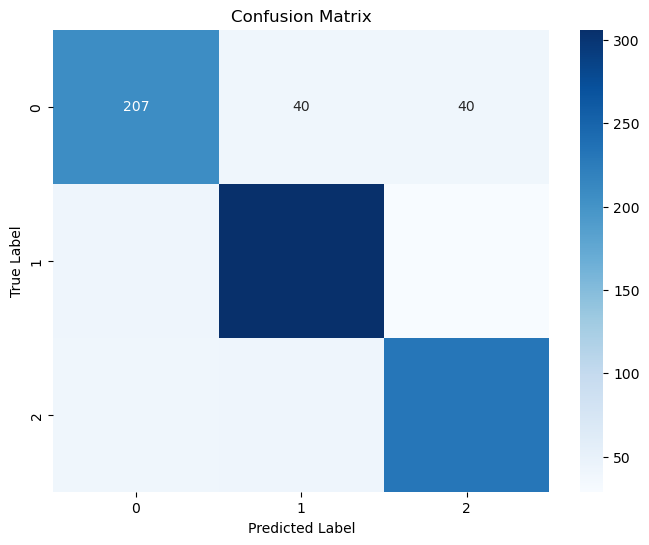

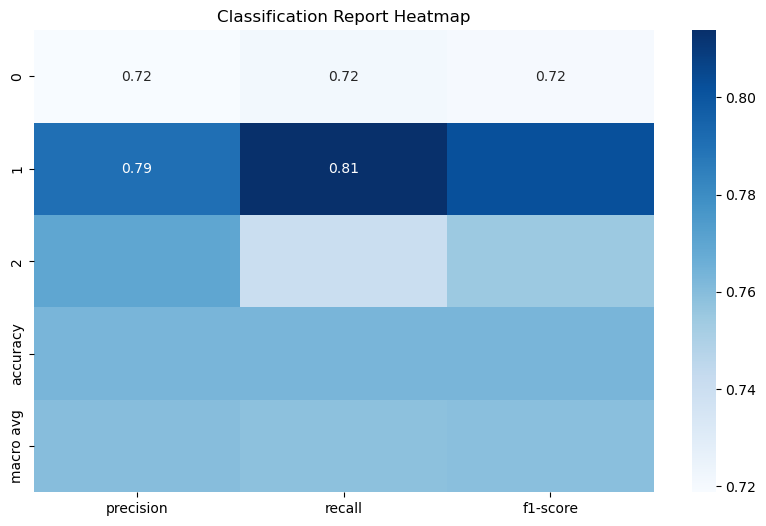

In [31]:

# Classification Report
class_report = classification_report(y_test, predictions, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("\nHere is the classification report:") 
print(classification_report(y_test, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualisasi Classification Report
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()
